In [146]:
# Raster I/O and math
import rasterio
from rasterio.warp import calculate_default_transform
from rasterstats import zonal_stats

# Image processing
import numpy as np
from skimage import exposure
from cv2 import GaussianBlur

# Blob detection
from math import sqrt
from skimage.feature import blob_log

# Others
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osmnx import gdf_from_place
from geopy.geocoders import Nominatim
from tqdm import tqdm

%matplotlib inline

# Read in the Gridded Population and Black Marble rasters

In [349]:
GPW_PATH = 'input/Resampled_BlackMarble_GPW/gpw_v4_population_count_20151.tif'
BM_PATH = 'input/Resampled_BlackMarble_GPW/BlackMarble_mosaic_resample_32BIT_normalize.tif'

In [350]:
with rasterio.open(GPW_PATH) as src:
    
    # The profile contains the metadata
    GPW_profile = src.profile
    
    # Read the first and only band into an array
    GPW = src.read(1)

In [351]:
GPW.shape

(17400, 43200)

In [ ]:
del GPW

In [4]:
with rasterio.open(BM_PATH) as src:
    
    # The profile contains the metadata
    BM_profile = src.profile
    
    # Read the first and only band into an array
    BM = src.read(1)

# Image processing

### Replace huge negative `nodata` values with zeros

In [5]:
GPW[ GPW < -10000000000 ] = 0
BM[ BM < -10000000000 ] = 0

### Remove the concept of `nodata`

In [6]:
del GPW_profile['nodata']
del BM_profile['nodata']

### Normalization by Scaling Between 0 and 1

In [7]:
def min_max_scaler(A):
    results = (A - A.min()) / (A.max() - A.min())
    return results

GPW_scaled = min_max_scaler(GPW)
BM_scaled = min_max_scaler(BM)

### Smooth images with Gaussian Blur

Make GPW kernel a bit bigger to compensate for the fact that Black Marble is already somewhat blurred.

In [8]:
GPW_kernel_size = (15,15)
GPW_gaussian = GaussianBlur(GPW_scaled,GPW_kernel_size,0)

In [9]:
BM_kernel_size = (11,11)
BM_gaussian = GaussianBlur(BM_scaled,BM_kernel_size,0)

### Contrast Stretching

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [10]:
def contrast_stretch(img, pmin, pmax):
    pmin, pmax = np.percentile(img, (pmin, pmax))
    img_rescale = exposure.rescale_intensity(img, in_range=(pmin, pmax))
    return img_rescale

Give GPW a little more contrast enhancement because Black Marble is already brighter.

In [11]:
GPW_gaussian_enhanced = contrast_stretch(GPW_gaussian, 0.75, 99.25)

In [12]:
BM_gaussian_enhanced = contrast_stretch(BM_gaussian, 0.075, 99.925)

### Save to GeoTIFF

In [13]:
with rasterio.open('output/GPW_smoothed.tif', 'w', **GPW_profile) as dst:
    dst.write(GPW_gaussian_enhanced, 1)

/anaconda/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [14]:
with rasterio.open('output/BM_smoothed.tif', 'w', **BM_profile) as dst:
    dst.write(BM_gaussian_enhanced, 1)

# Calculate difference between the rasters

First we calculate Gridded Population of the World minus Black Marble.

In [15]:
GPW_minus_BM_smoothed = GPW_gaussian_enhanced - BM_gaussian_enhanced

Delete the gaussian enhanced layers from memory.

In [16]:
del GPW_gaussian_enhanced
del BM_gaussian_enhanced

Save smoothed difference to geotiff.

In [17]:
GPW_minus_BM_profile = GPW_profile

with rasterio.open('output/GPW_minus_BM_smoothed.tif', 'w', **GPW_minus_BM_profile) as dst:
    dst.write(GPW_minus_BM_smoothed, 1)

We also calculate Black Marble minus Gridded Population of the World (it will be handy to have this as a separate array for blob detection).

In [18]:
BM_minus_GPW_smoothed = -1 * GPW_minus_BM_smoothed

Also save the unsmoothed difference to geotiff.

In [19]:
GPW_minus_BM = GPW_scaled - BM_scaled

In [20]:
with rasterio.open('output/GPW_minus_BM_raw.tif', 'w', **GPW_minus_BM_profile) as dst:
    dst.write(GPW_minus_BM, 1)

Delete unsmoothed arrays from memory

In [21]:
del GPW_minus_BM
del GPW_scaled
del BM_scaled

# More people than lights in smoothed difference

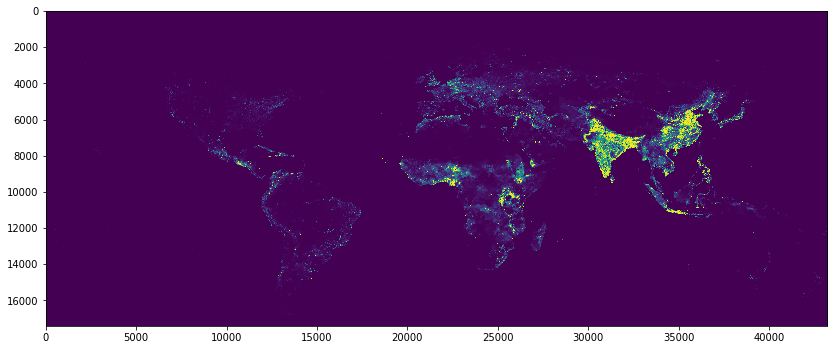

In [22]:
GPW_minus_BM_gte_0 = GPW_minus_BM_smoothed.copy()
np.place(GPW_minus_BM_gte_0, GPW_minus_BM_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(GPW_minus_BM_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [63]:
GPW_minus_BM_path = 'output/GPW_minus_BM_gte_0.tif'

In [23]:
with rasterio.open(GPW_minus_BM_path, 'w', **GPW_profile) as dst:
    dst.write(GPW_minus_BM_gte_0, 1)

In [24]:
del GPW_minus_BM_gte_0

# More lights than people (smoothed)

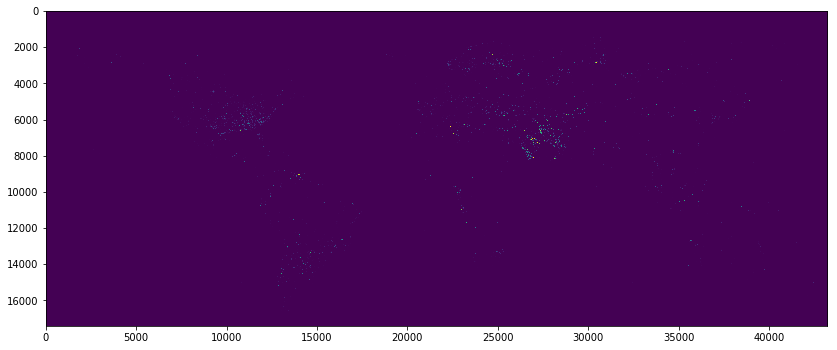

In [25]:
BM_minus_GPW_gte_0 = BM_minus_GPW_smoothed.copy()
np.place(BM_minus_GPW_gte_0, BM_minus_GPW_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(BM_minus_GPW_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [64]:
BM_minus_GPW_path = 'output/BM_minus_GPW_gte_0.tif'

In [26]:
with rasterio.open(BM_minus_GPW_path, 'w', **GPW_profile) as dst:
    dst.write(BM_minus_GPW_gte_0, 1)

In [27]:
del BM_minus_GPW_gte_0

Delete all of the big image arrays to save memory. They are no longer needed 

In [28]:
del BM
del BM_gaussian
del BM_minus_GPW_smoothed
del GPW
del GPW_gaussian
del GPW_minus_BM_smoothed